In [1]:
# !sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-ind is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import string

In [3]:
import pytesseract

In [4]:
dir='dataCrop'  # dir for cropped bounding box
file_path='/content/'

In [5]:
ori_img=file_path+'ktp5.png'
model = tf.keras.models.load_model('/content/my_model.h5')

In [26]:
def processImage(img):
    img=cv2.imread(img,0)
    plt.imshow(img)
    ret,img=cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU,img)
    img=cv2.resize(img,(512,512))
    img= np.expand_dims(img,axis=-1)
    img=img/255
    img=np.expand_dims(img,axis=0)
    return img

def processMask(mask,ori):
    img = cv2.imread(mask,0) 
    cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
    ori_img=cv2.imread(ori)
    ori_img=cv2.resize(ori_img,(512,512))
    contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    i=0
    for c in contours:
    # get the bounding rect
      x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
      cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
      if(w>15 and h>15) :
        new=ori_img[y:y+h,x:x+w]
        cv2.imwrite(file_path+dir+'/{}.png'.format(i),new)
        i+=1
      # elif h>29:
      #   new=ori_img[y:y+h,x:x+w]
      #   cv2.imwrite('/content/nikCrop/{}.png'.format("nik"),new)
      # cv2.drawContours(img, contours, 1, (512, 512, 1), 1)
    plt.imshow(img)
    cv2.imwrite("output.png",ori_img)

def deleteFile(path):
  dir=os.listdir(path)
  for filename in dir:
    try:
      os.remove(dir_path+filename)  
    except OSError as e:
      print("no file")

def createDir(file_path,dir):
  dir_path=os.path.join(file_path+dir+'/')
  if not os.path.exists(os.path.join(file_path,dir)):
    os.mkdir(file_path+dir)
  return dir_path

def normalizeAlamat(list_text,indexGender): # penggabungan alamat yang terpisah (jika terpisah)
  x=2
  result_index=7
  found=False
  if indexGender==7 :
    if list_text[indexGender-x][4] !='/':
      list_text[indexGender-x]=list_text[indexGender-x][:4]+"/"+list_text[indexGender-x][5:]
  elif indexGender ==8:
    x+=1
    if list_text[indexGender-x][4] !='/':
      list_text[indexGender-x]=list_text[indexGender-x][:4]+"/"+list_text[indexGender-x][5:]
    else :
      list_text[indexGender-x+1]=list_text[indexGender-x+1].rstrip("\n")+list_text[indexGender-x+2]
      del list_text[indexGender-x+2]
  elif indexGender==9:
    x+=2
    if list_text[indexGender-x][4] !='/':
      list_text[indexGender-x]=list_text[indexGender-x][:4]+"/"+list_text[indexGender-x][5:]
    else:
      list_text[indexGender-x+1]=list_text[indexGender-x+1].rstrip("\n")+list_text[indexGender-x+2].rstrip("\n")+list_text[indexGender-x+3]
      del list_text[indexGender-x+2]
      del list_text[indexGender-x+3]
  return list_text

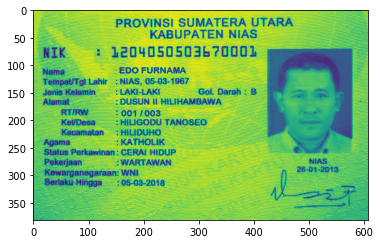

In [7]:
img=processImage(ori_img)

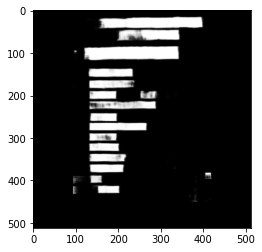

In [8]:
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [9]:
plt.imsave('mask.JPG',pred)

In [10]:
dir_path=createDir(file_path,dir)

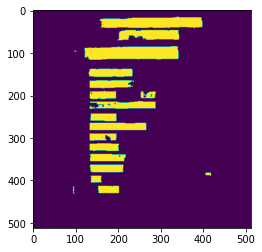

In [11]:
processMask(file_path+'mask.JPG',ori_img)

In [12]:
list_crop=os.listdir(dir_path)
filename_list=[filename.split(".")[0]for filename in list_crop]
filename_list.sort()

In [13]:
text_list=[]

In [14]:
i=0
for filename in filename_list:
  name='/content/dataCrop/{}.png'.format(i)
  t1 = pytesseract.image_to_string(name,lang='ind',config='--psm 10')
  text_list.append(t1.title())
  i+=1
print(text_list)

['03-2014\n\x0c', 'Nni\n\x0c', 'Wartawan\n\x0c', 'Cerai Hidup\n\x0c', 'Katholik\n\x0c', 'Hiliduho\n\x0c', 'Hiligodu Tanoseo\n\x0c', '001 /003\n\x0c', 'Dusun Ii Hilihambawa\n\x0c', 'Gol. L\n\x0c', 'Laki-Laki\n\x0c', 'Nias, 05-03-196/\n\x0c', 'Edo Furnama\n\x0c', '1201050503570001\n\x0c', 'Bupaten Nias\n\x0c', ')Vinsi Sumatera Utara\n\x0c']


In [28]:
unwanted_text=['Gol D:','Gol D','Gol','#Umur Hidup','Id',
               'Seumur Hidup\n','Bupa\n','Beli\n','Belu','Belum',
               'Seumur Hidu','Hp','Belum Kawin','Belum Kaw','Gol. Darah',
               'Gol. Dar','Gol. Da','Gol.','Ga','Umur Hie','062017','“1',
               ')Vin','Jp','Ri','03-2014', 'Gol. L', 'Cerai Hidup', 'Cerai Mati', '']
               
# textfile = open("OCR.txt", "w")

sentence=''.join(text_list)
sentence=sentence.split("\n\x0c")
print(sentence)

['03-2014', 'Nni', 'Wartawan', 'Cerai Hidup', 'Katholik', 'Hiliduho', 'Hiligodu Tanoseo', '001 /003', 'Dusun Ii Hilihambawa', 'Gol. L', 'Laki-Laki', 'Nias, 05-03-196/', 'Edo Furnama', '1201050503570001', 'Bupaten Nias', ')Vinsi Sumatera Utara', '']


In [16]:
value=[]

In [27]:
try :
  index=sentence.index('Perempuan')
except:
  index=sentence.index('Laki-Laki')

sentence=normalizeAlamat(sentence,index)

for i in sentence:
  if i not in unwanted_text:
    value.append(i)

print(value)

['Nni', 'Wartawan', 'Katholik', 'Hiliduho', 'Hiligodu Tanoseo', '001 /003', 'Dusun Ii Hilihambawa', 'Laki-Laki', 'Nias, 05-03-196/', 'Edo Furnama', '1201050503570001', 'Bupaten Nias', ')Vinsi Sumatera Utara', 'Nni', 'Wartawan', 'Katholik', 'Hiliduho', 'Hiligodu Tanoseo', '001 /003', 'Dusun Ii Hilihambawa', 'Laki-Laki', 'Nias, 05-03-196/', 'Edo Furnama', '1201050503570001', 'Bupaten Nias', ')Vinsi Sumatera Utara', 'Nni', 'Wartawan', 'Katholik', 'Hiliduho', 'Hiligodu Tanoseo', '001 /003', 'Dusun Ii Hilihambawa', 'Laki-Laki', 'Nias, 05-03-196/', 'Edo Furnama', '1201050503570001', 'Bupaten Nias', ')Vinsi Sumatera Utara', 'Nni', 'Wartawan', 'Katholik', 'Hiliduho', 'Hiligodu Tanoseo', '001 /003', 'Dusun Ii Hilihambawa', 'Laki-Laki', 'Nias, 05-03-196/', 'Edo Furnama', '1201050503570001', 'Bupaten Nias', ')Vinsi Sumatera Utara', 'Nni', 'Wartawan', 'Katholik', 'Hiliduho', 'Hiligodu Tanoseo', '001 /003', 'Dusun Ii Hilihambawa', 'Laki-Laki', 'Nias, 05-03-196/', 'Edo Furnama', '1201050503570001', 

In [29]:
key_value=["kewarganegaraan","Pekerjaan","Agama","Kecamatan","Kel/Desa","RT/RW","Alamat","Jenis kelamin","Tempat/tgl lahir","Nama","NIK","Kabupaten/Kota","Provinsi"]

In [30]:
dict_from_list = dict(zip(key_value, value)) 
print(dict_from_list)

{'kewarganegaraan': 'Nni', 'Pekerjaan': 'Wartawan', 'Agama': 'Katholik', 'Kecamatan': 'Hiliduho', 'Kel/Desa': 'Hiligodu Tanoseo', 'RT/RW': '001 /003', 'Alamat': 'Dusun Ii Hilihambawa', 'Jenis kelamin': 'Laki-Laki', 'Tempat/tgl lahir': 'Nias, 05-03-196/', 'Nama': 'Edo Furnama', 'NIK': '1201050503570001', 'Kabupaten/Kota': 'Bupaten Nias', 'Provinsi': ')Vinsi Sumatera Utara'}


In [31]:
# deleteFile(dir_path)